# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [296]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [297]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)
print len(train_data), len(train_labels)


('training label shape:', (2034,))
('test label shape:', (677,))
('dev label shape:', (676,))
('labels names:', ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'])
2034 2034


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [298]:
def P1(num_examples=5):
    for data, labels in zip(train_data, train_labels):
        print train_data[:5], train_labels[:5]
        break
    
P1()

[u"Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych", u'\n\nSeems to be, barring evidence to the contrary, that Koresh was simply\nanother deranged fanatic who thought it neccessary to take a whole bunch of\nfolks with him, children and all, to satisfy his delusional mania. Jim\nJones, circa 1993.\n\n\nNope - fruitcakes like Koresh have been demonstrating such evil corruption\nfor centuries.', u"\n >In article <1993Apr19.02

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [299]:
import numpy as np
#from __future__ import division
vocab = ["atheism", "graphics", "space", "religion"]


def P2():
    vectorizer = CountVectorizer()
    a = vectorizer.fit_transform(train_data)
    #size of the vocabulary
    print 'The size of the vocabulary is: ', len(vectorizer.vocabulary_)
    #Fraction of entries in the matrix that are non-zero
    print 'Fraction of entries that are non-zero is: 63562/8912028'
    #0th and last feature strings
    print 'The 0th and last feature strings are: ', vectorizer.get_feature_names()[0], vectorizer.get_feature_names()[-1]
    vectorizer = CountVectorizer(min_df=1, vocabulary = ["atheism", "graphics", "space", "religion"])
    b = vectorizer.fit_transform(train_data)
    print b.shape
    print b.nnz
    print 'With the new four word vocabulary, the average number of non-zero features is 546'
    vectorizer = CountVectorizer(input=train_data, ngram_range=(2,3), analyzer='char')
    c = vectorizer.fit_transform(train_data).toarray()
    print c.shape
    print "The size of the vocabulary using bigram and trigram character features is: ", 2034*35478
    vectorizer = CountVectorizer(input=train_data, min_df=10)
    d = vectorizer.fit_transform(train_data).toarray()
    print d.shape
    print 'The size of the vocabulary when using min_df=10 is: ', 2034*3064
    vectorizer_dev = CountVectorizer(input = dev_data)
    e = vectorizer_dev.fit_transform(dev_data)
    dev_vocab = set(vectorizer_dev.vocabulary_)
    vectorizer_test = CountVectorizer(input = train_data)
    f = vectorizer_test.fit_transform(train_data)
    train_vocab = set(vectorizer_test.vocabulary_)
    print len(list(set(dev_vocab)))
    print len([x for x in dev_vocab if x not in train_vocab])
    print 'the fraction of the words from dev data missiong in dev data is 4027/16246, or ', 0.25


    

P2()

The size of the vocabulary is:  26879
Fraction of entries that are non-zero is: 63562/8912028
The 0th and last feature strings are:  00 zyxel
(2034, 4)
546
With the new four word vocabulary, the average number of non-zero features is 546
(2034, 35478)
The size of the vocabulary using bigram and trigram character features is:  72162252
(2034, 3064)
The size of the vocabulary when using min_df=10 is:  6232176
16246
4027
the fraction of the words from dev data missiong in dev data is 4027/16246, or  0.25


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [306]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

def P3():
    vectorizer = CountVectorizer() 
    train_data_counts = vectorizer.fit_transform(train_data)
    dev_data_counts = vectorizer.transform(dev_data)
    #clf = neighbors.KNeighborsClassifier()
    clf = GridSearchCV(KNeighborsClassifier(), n_neighbors)
    clf.fit(train_data_counts, train_labels)
    predicted = clf.predict(dev_data_counts)
    print metrics.accuracy_score(predicted, dev_labels)
    print metrics.f1_score(predicted, dev_labels, average='micro')
    print 'Optimal value for k: ', clf.best_params_
    clf2 = GridSearchCV(BernoulliNB(), alphas)
    clf2.fit(train_data_counts, train_labels)
    predicted2 = clf2.predict(dev_data_counts)
    print 'NB: ', metrics.accuracy_score(predicted2, dev_labels)
    print 'NB f1 score: ', metrics.f1_score(predicted2, dev_labels, average='micro')  
    print 'Optimal value for alpha: ', clf2.best_params_
    clf3 = GridSearchCV(LogisticRegression(), reg)
    clf3.fit(train_data_counts, train_labels)
    predicted3 = clf3.predict(dev_data_counts)
    print 'Logit: ', metrics.accuracy_score(predicted3, dev_labels)
    print 'Logit f1 score: ', metrics.f1_score(predicted3, dev_labels, average='micro')
    print 'Optimal value for C: ', clf3.best_params_
    weights = clf3.best_estimator_.coef_
    print [sum([x ** 2 for x in weights[n]]) for n in range(0, len(weights))]
    print clf3.grid_scores_
    for items in c_values:
        clf4 = LogisticRegression(C=items)
        clf4.fit(train_data_counts, train_labels)
        predicted4 = clf4.predict(dev_data_counts)
        print 'Sum of squared weight values for each class: \n'
        print [sum([x ** 2 for x in clf4.coef_[n]]) for n in range(0, len(clf4.coef_))]

n_neighbors = [{'n_neighbors': np.arange(1,5)}]    
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
reg = [{'C': [.0001, .01, .05, 0.1,  .2, .3, .5, 1 , 10, 100, 1000]}]
c_values = [.0001, .01, .05, 0.1,  .2, .3, .5, 1 , 10, 100, 1000]

P3()

0.383136094675
0.383136094675
Optimal value for k:  {'n_neighbors': 1}
NB:  0.698224852071
NB f1 score:  0.698224852071
Optimal value for alpha:  {'alpha': 0.0001}
Logit:  0.713017751479
Logit f1 score:  0.713017751479
Optimal value for C:  {'C': 0.2}
[49.747626091588749, 42.745401464104731, 49.330619544924588, 42.668313996094497]
[mean: 0.50688, std: 0.03202, params: {'C': 0.0001}, mean: 0.73402, std: 0.00750, params: {'C': 0.01}, mean: 0.76303, std: 0.00332, params: {'C': 0.05}, mean: 0.76647, std: 0.00299, params: {'C': 0.1}, mean: 0.77630, std: 0.00198, params: {'C': 0.2}, mean: 0.77089, std: 0.00230, params: {'C': 0.3}, mean: 0.77139, std: 0.00337, params: {'C': 0.5}, mean: 0.76303, std: 0.00306, params: {'C': 1}, mean: 0.75418, std: 0.00137, params: {'C': 10}, mean: 0.74730, std: 0.00421, params: {'C': 100}, mean: 0.74336, std: 0.01256, params: {'C': 1000}]
Sum of squared weight values for each class: 

[0.0077017494467523737, 0.011941200310606512, 0.0094350768656394305, 0.009102

ANSWER:

a: Nearest neighbors does not work well for this type of problem because the distinct words that classify each \
document is a small subset of the words in each category. KNN, without giving heavier weights to certain words \
will fail to properly categorize because of the high number of similar words in each category.

b: My f1_score is actually higher for logistic regression. This is likely because NB is giving high weights to repeated and similar features, while logistic regression corrects for these correlated featurres by lowering their weights. This would lead to a higher accuracy on the dev set.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [301]:
from sklearn.feature_extraction.text import TfidfVectorizer
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

def P4():
    vectorizer = TfidfVectorizer() 
    train_data_counts = vectorizer.fit_transform(train_data)
    dev_data_counts = vectorizer.transform(dev_data)
    logit = LogisticRegression()
    logit.fit(train_data_counts, train_labels)
    logit.predict(dev_data_counts)
    idf = vectorizer.idf_
    print '\t', ['alt.atheism', 'sci.space', 'comp.graphics', 'talk.religion.misc']
    for i in range(len(logit.coef_)):
        sorted_weights = sorted(logit.coef_[i])
        top_weights = sorted_weights[-5:]
        #print top_weights
        for weights in top_weights:
            index = logit.coef_[i].tolist().index(weights)
            print vectorizer.get_feature_names()[index], '\t', logit.coef_[:, index]




P4()

	['alt.atheism', 'sci.space', 'comp.graphics', 'talk.religion.misc']
bobby 	[ 1.64446797 -0.47490377 -0.57718713 -0.69738609]
atheists 	[ 1.69940656 -0.43172436 -0.60300781 -0.90558928]
islam 	[ 1.84709832 -0.54021021 -0.7282085  -0.68003349]
religion 	[ 1.95522998 -0.98315954 -1.31486908  0.25389442]
atheism 	[ 2.17239658 -0.7690863  -0.82429017 -0.84797607]
3d 	[-0.67361769  2.04381006 -1.05789205 -0.58262134]
files 	[-0.94829185  2.12638604 -0.81855027 -0.94595413]
file 	[-0.66366705  2.44987212 -1.3939139  -0.91365542]
image 	[-0.94861908  2.60338375 -1.39513925 -0.77746394]
graphics 	[-1.45853394  4.03867113 -2.25569511 -1.27458554]
moon 	[-0.85991597 -0.94707703  1.92333672 -0.40856257]
launch 	[-0.78567104 -0.86528508  2.01019631 -0.69237602]
orbit 	[-0.73643185 -1.00528622  2.17822584 -0.73398721]
nasa 	[-1.05386901 -1.01426816  2.50335279 -1.02259809]
space 	[-2.16368201 -2.50088606  5.48995446 -2.10169937]
god 	[ 1.28495653 -1.66670715 -2.12787249  1.61891353]
he 	[ 0.4417045

ANSWER:

            ['alt.atheism', 'sci.space', 'comp.graphics', 'talk.religion.misc']
    bobby 	[ 1.64446797 -0.47490377 -0.57718713 -0.69738609]
atheists 	[ 1.69940656 -0.43172436 -0.60300781 -0.90558928]
    islam 	[ 1.84709832 -0.54021021 -0.7282085  -0.68003349]
religion 	[ 1.95522998 -0.98315954 -1.31486908  0.25389442]
atheism 	[ 2.17239658 -0.7690863  -0.82429017 -0.84797607]
        3d 	[-0.67361769  2.04381006 -1.05789205 -0.58262134]
    files 	[-0.94829185  2.12638604 -0.81855027 -0.94595413]
    file 	[-0.66366705  2.44987212 -1.3939139  -0.91365542]
    image 	[-0.94861908  2.60338375 -1.39513925 -0.77746394]
graphics 	[-1.45853394  4.03867113 -2.25569511 -1.27458554]
    moon 	[-0.85991597 -0.94707703  1.92333672 -0.40856257]
    launch 	[-0.78567104 -0.86528508  2.01019631 -0.69237602]
    orbit 	[-0.73643185 -1.00528622  2.17822584 -0.73398721]
    nasa 	[-1.05386901 -1.01426816  2.50335279 -1.02259809]
    space 	[-2.16368201 -2.50088606  5.48995446 -2.10169937]
    god 	[ 1.28495653 -1.66670715 -2.12787249  1.61891353]
        he 	[ 0.44170451 -1.4511845  -1.10360071  1.91790632]
christians 	[-0.75927014 -0.59187126 -0.78725513  1.96685437]
christian 	[-0.81594033 -0.72055497 -0.85813662  2.23451585]
    jesus 	[-0.92683759 -0.75589786 -1.17115551  2.24613966]

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [302]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    s = s.lower()
    s = s.rstrip()
    s = s.lstrip()
    s = re.sub('[^0-9a-zA-Z]+', '*', s)
    s = re.sub('[0-9]+', '0', s)
    s = re.sub(r'[aeiou]', '', s, flags=re.IGNORECASE)
    return s

### STUDENT END ###

def P5():
    vectorizer = CountVectorizer(preprocessor=better_preprocessor) 
    train_data_counts = vectorizer.fit_transform(train_data)
    dev_data_counts = vectorizer.transform(dev_data)
    logit = LogisticRegression()
    logit.fit(train_data_counts, train_labels)
    predicted = logit.predict(dev_data_counts)
    print metrics.accuracy_score(predicted, dev_labels)
    print len(vectorizer.vocabulary_)
    vectorizer_empty = CountVectorizer(preprocessor=empty_preprocessor) 
    train_data_counts_empty = vectorizer_empty.fit_transform(train_data)
    dev_data_counts_empty = vectorizer_empty.transform(dev_data)
    logit.fit(train_data_counts_empty, train_labels)
    predicted_empty = logit.predict(dev_data_counts_empty)
    print metrics.accuracy_score(predicted_empty, dev_labels)
    print len(vectorizer_empty.vocabulary_)

print "The size of the dictionary was reduced from 33291 to 17715. I lowercased and disemvowled all words. I also \
replaced digits with a single feature and removed special characters."
    

### STUDENT END ###
P5()

The size of the dictionary was reduced from 33291 to 17715. I lowercased and disemvowled all words. I also replaced digits with a single feature and removed special characters.
0.711538461538
17715
0.707100591716
33291


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

436
410
390
373
26879
26879
26879
26879
The l1 model reduced the vocab sizes to 436, 410, 390, and 373 when removing zeros.     The l2 model did not drive any weights down to 0, leaving the number of weights at 26879.
0.244082840237 0
0.244082840237 0
0.244082840237 0
0.244082840237 0
0.244082840237 0
0.244082840237 0
0.244082840237 0
0.244082840237 0
0.46449704142 9
0.46449704142 9
0.46449704142 7
0.46449704142 10
0.585798816568 42
0.585798816568 40
0.585798816568 35
0.585798816568 53
0.618343195266 82
0.618343195266 61
0.618343195266 62
0.618343195266 89
0.656804733728 140
0.656804733728 83
0.656804733728 111
0.656804733728 140
0.665680473373 170
0.665680473373 113
0.665680473373 136
0.665680473373 195
0.662721893491 213
0.662721893491 153
0.662721893491 178
0.662721893491 269
0.646449704142 262
0.646449704142 213
0.646449704142 227
0.646449704142 356
0.636094674556 363
0.636094674556 349
0.636094674556 362
0.636094674556 356
0.619822485207 368
0.619822485207 366
0.619822485207 370
0

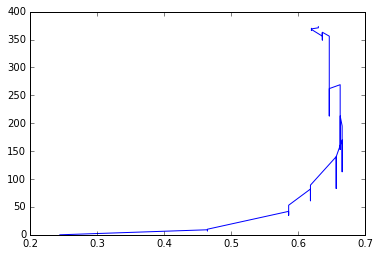

In [303]:
def P6():
    #Keep this random seed here to make comparison easier.
    np.random.seed(0)
    vectorizer = CountVectorizer() 
    train_data_counts = vectorizer.fit_transform(train_data)
    dev_data_counts = vectorizer.transform(dev_data)
    logit = LogisticRegression(penalty='l1')
    logit.fit(train_data_counts, train_labels)
    predicted = logit.predict(dev_data_counts)
    for i in range(len(logit.coef_)):
        print len(logit.coef_[i][logit.coef_[i] != 0])
        x = np.array(logit.coef_[i])
        non_zeros = np.where(x != 0)[0]
    logit_l2 = LogisticRegression(penalty='l2')
    logit_l2.fit(train_data_counts, train_labels)
    predicted = logit_l2.predict(dev_data_counts)
    for i in range(len(logit_l2.coef_)):
        print len(logit_l2.coef_[i][logit_l2.coef_[i] != 0])
    print "The l1 model reduced the vocab sizes to 436, 410, 390, and 373 when removing zeros. \
    The l2 model did not drive any weights down to 0, leaving the number of weights at 26879."
    vocab = [vectorizer.get_feature_names()[i] for i in non_zeros]
    vectorizer_reduced = CountVectorizer(min_df=1, vocabulary = vocab)
    train_data_counts_reduced = vectorizer_reduced.fit_transform(train_data)
    dev_data_counts_reduced = vectorizer_reduced.transform(dev_data)
    acc_list = []
    vocab_len = []
    for items in c_values:
        logit_c = LogisticRegression(penalty='l1', tol=0.01, C=items)
        logit_c.fit(train_data_counts_reduced, train_labels)
        predicted_c = logit_c.predict(dev_data_counts_reduced)
        acc = metrics.accuracy_score(predicted_c, dev_labels)
        for i in range(len(logit_c.coef_)):
            print acc, len(logit_c.coef_[i][logit_c.coef_[i] != 0])
            acc_list.append(acc)
            vocab_len.append(len(logit_c.coef_[i][logit_c.coef_[i] != 0]))
    plt.plot(acc_list, vocab_len)

            

c_values = [0.00000000001, .0001, .01, .05, 0.1,  .2, .3, .5, 1 , 10, 100, 1000]

P6()



(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [304]:
#('labels names:', ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'])
def P7():
    vectorizer = TfidfVectorizer() 
    train_data_counts = vectorizer.fit_transform(train_data)
    dev_data_counts = vectorizer.transform(dev_data)
    logit = LogisticRegression(C=100)
    logit.fit(train_data_counts, train_labels)
    predicted = logit.predict(dev_data_counts)
    R = []
    for items, labels in zip(logit.predict_proba(dev_data_counts), dev_labels):
        R.append(max(items)/items[labels])
    sorted_r = np.sort(R)
    top_r = sorted_r[-3:]
    print top_r
    print len(R)
    for rs in top_r:
        index = R.index(rs)
        print logit.predict_proba(dev_data_counts)[index], dev_labels[index]
P7()

[ 287.17920279  325.00408735  929.35805306]
676
[ 0.00242095  0.02006482  0.2822689   0.69524534] 0
[ 0.00291046  0.97974561  0.01432936  0.00301456] 3
[ 0.00196563  0.99372025  0.00324486  0.00106925] 3


ANSWER: The misc regligion and atheism categories seem easy to mix up. Potentially removing the word "atheism" from the general religion category can help improve the correct calling of the atheism category.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.